# Density evaluation

In [1]:
# import libraries
!pip install opencv-python
import sklearn
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading dataset

In [2]:
dataset_path='database_sclere/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

# load csv file
df = pd.read_csv(dataset_path+'hbvalue.csv', sep=';')

# cut the dataset only to indian dataset
df = df[df['dataset']=='ind']

df.head()


,dataset,paziente,foto1,foto2,hb,Nome Cognome,Sesso,Et?,Data Nascita,buona,Unnamed: 10
91,ind,1,20200118_164759,20200118_164733,"12,2",NaN,M,29,NaN,NaN,NaN
92,ind,2,20200124_154320,20200124_154319,8,NaN,F,36,NaN,NaN,NaN
93,ind,3,20200124_155439,20200124_155418,"10,7",NaN,F,30,NaN,NaN,NaN
94,ind,4,20200124_160524,20200124_160522,"8,3",NaN,F,39,NaN,NaN,NaN
95,ind,5,20200124_161455,20200124_161452,"7,8",NaN,F,29,NaN,NaN,NaN


# Loading photos

In [3]:
path_photos = dataset_path+'Dataset indiano/'
sclera_vessels = []
sclera_masks = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(row['paziente'] + "-") and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)
            sclera_vessels.append(sclera_vessel)
            break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:18<00:00,  5.19it/s]


# Preprocessing

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:01<00:00, 68.29it/s]


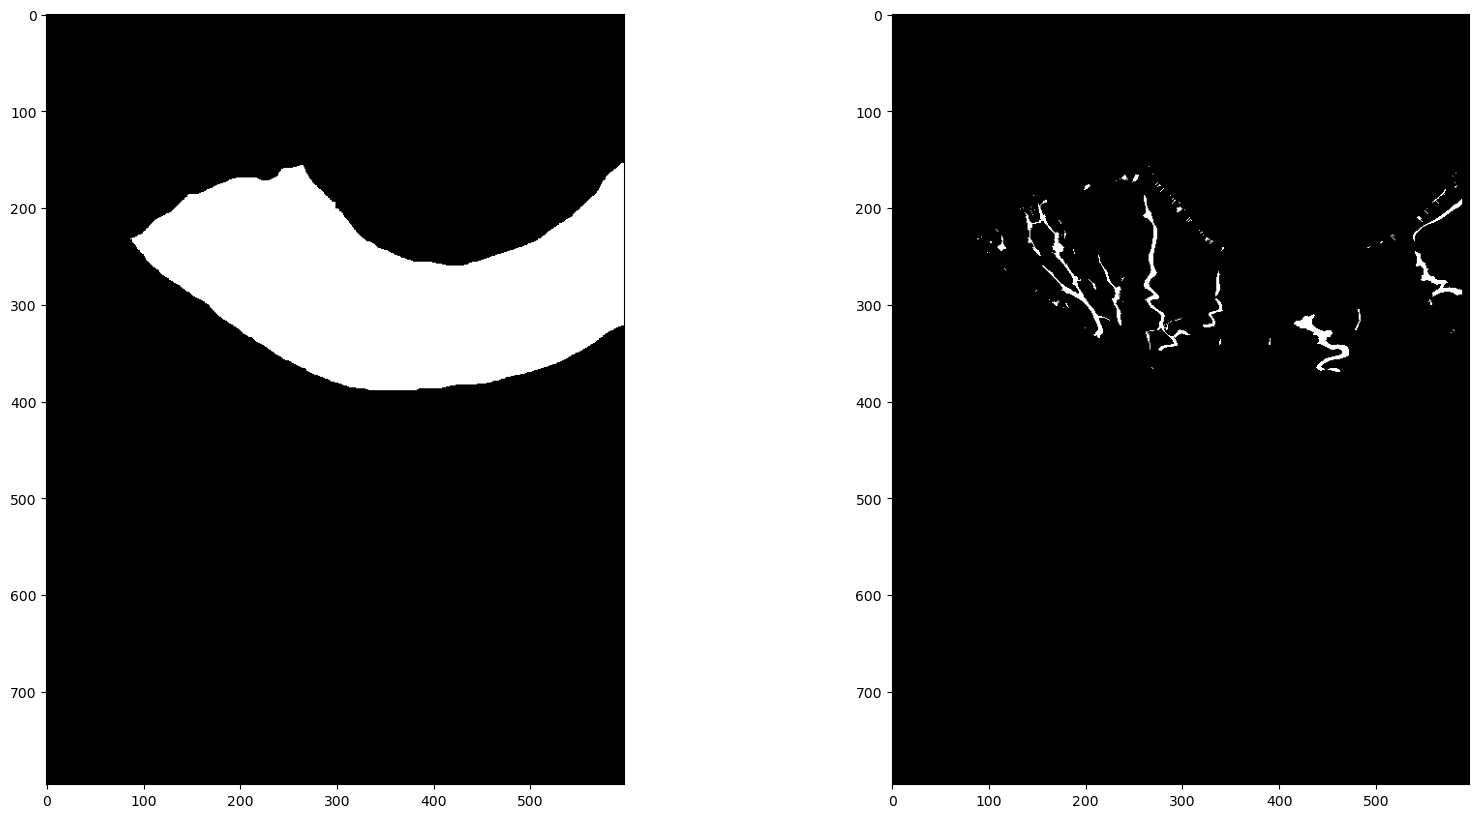

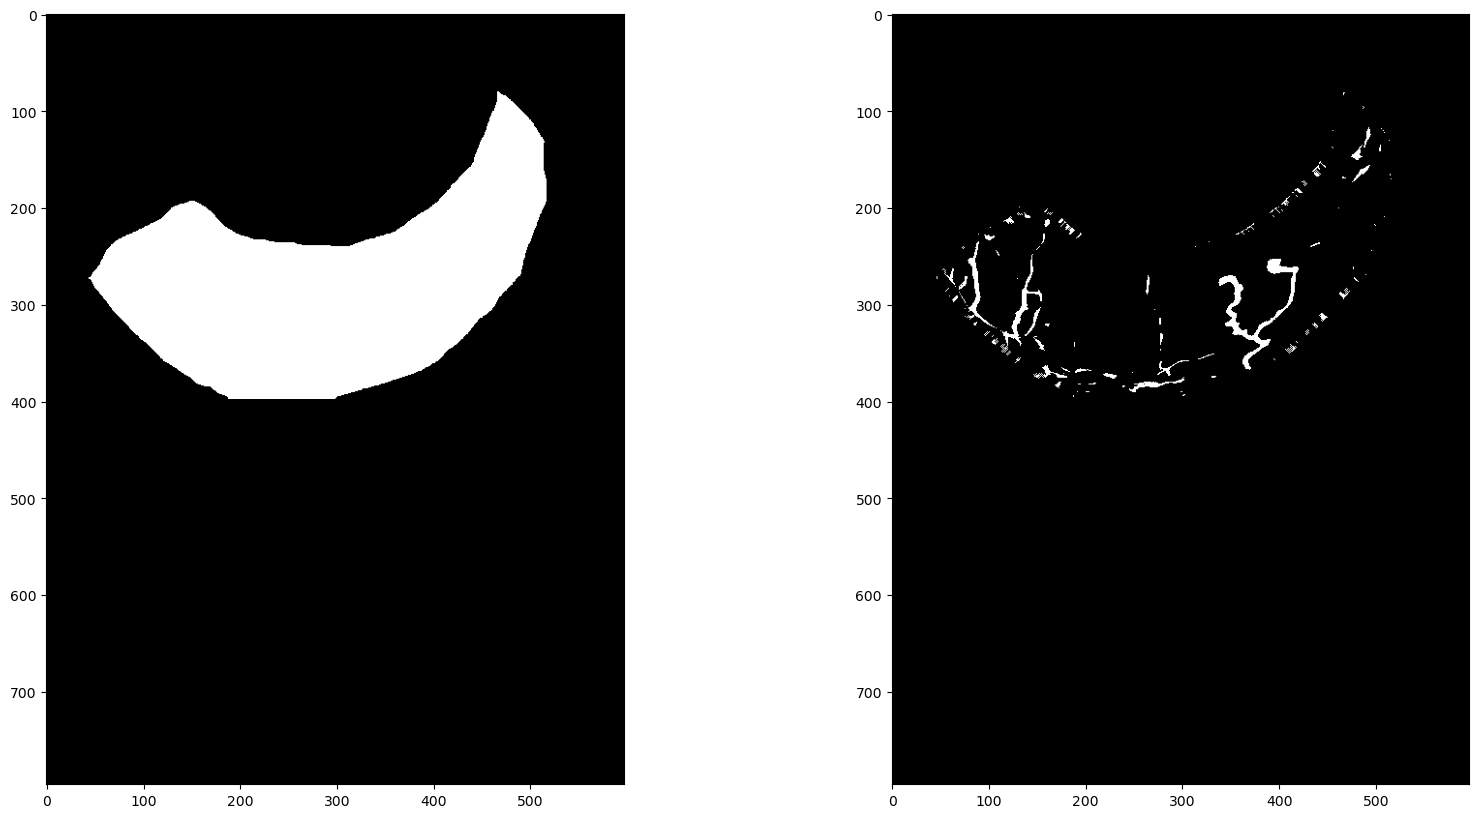

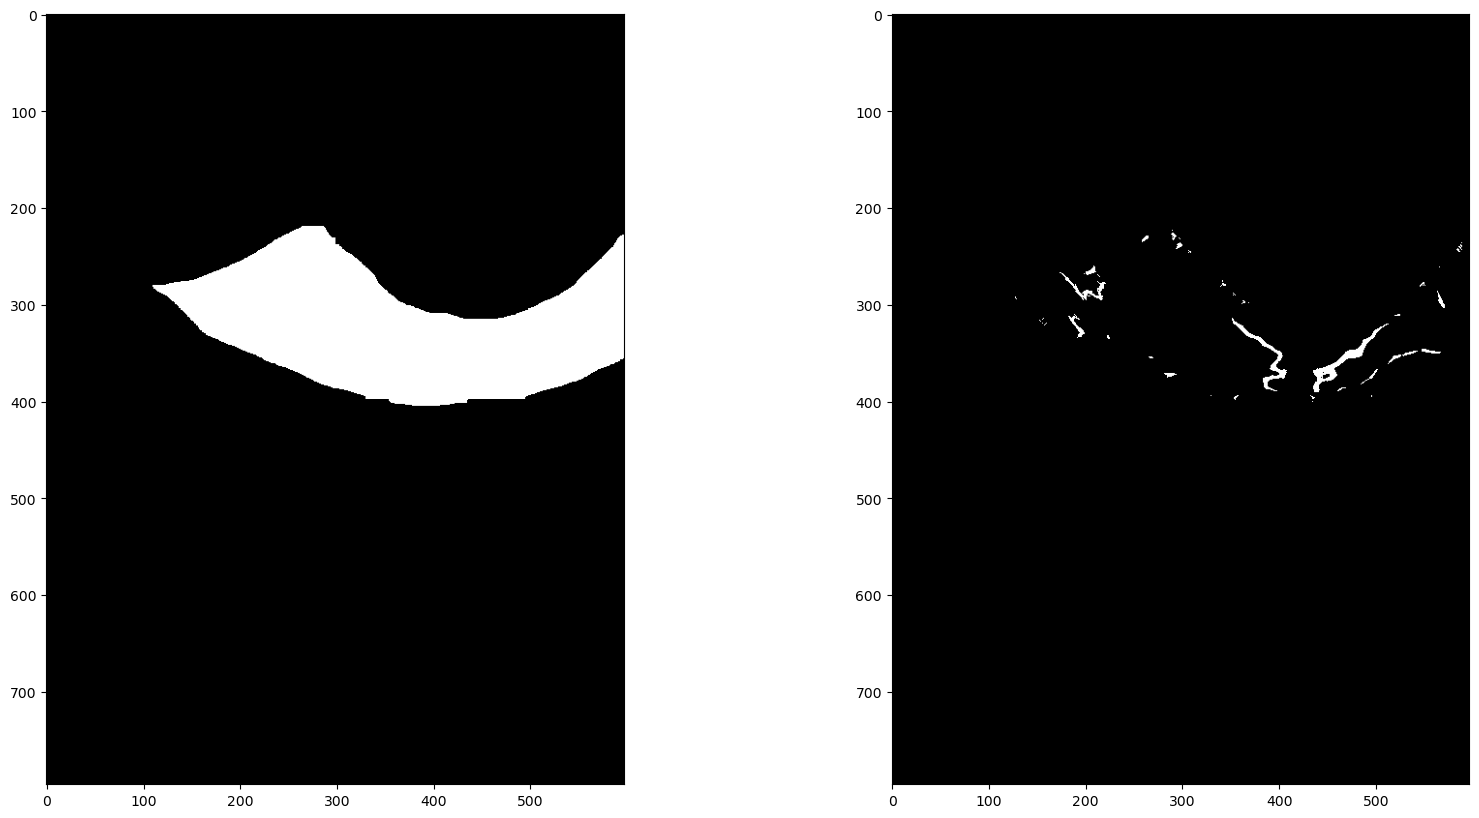

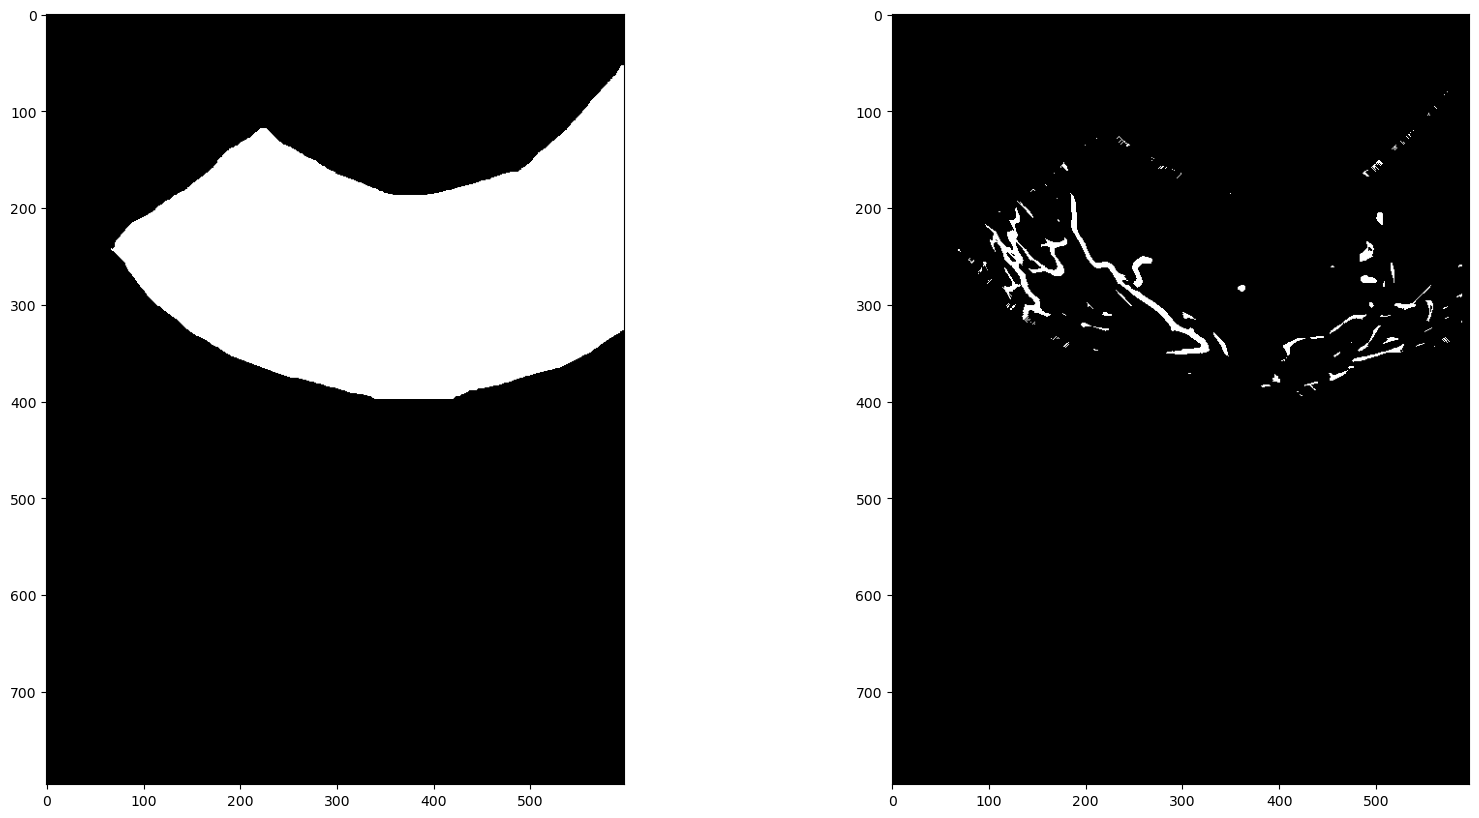

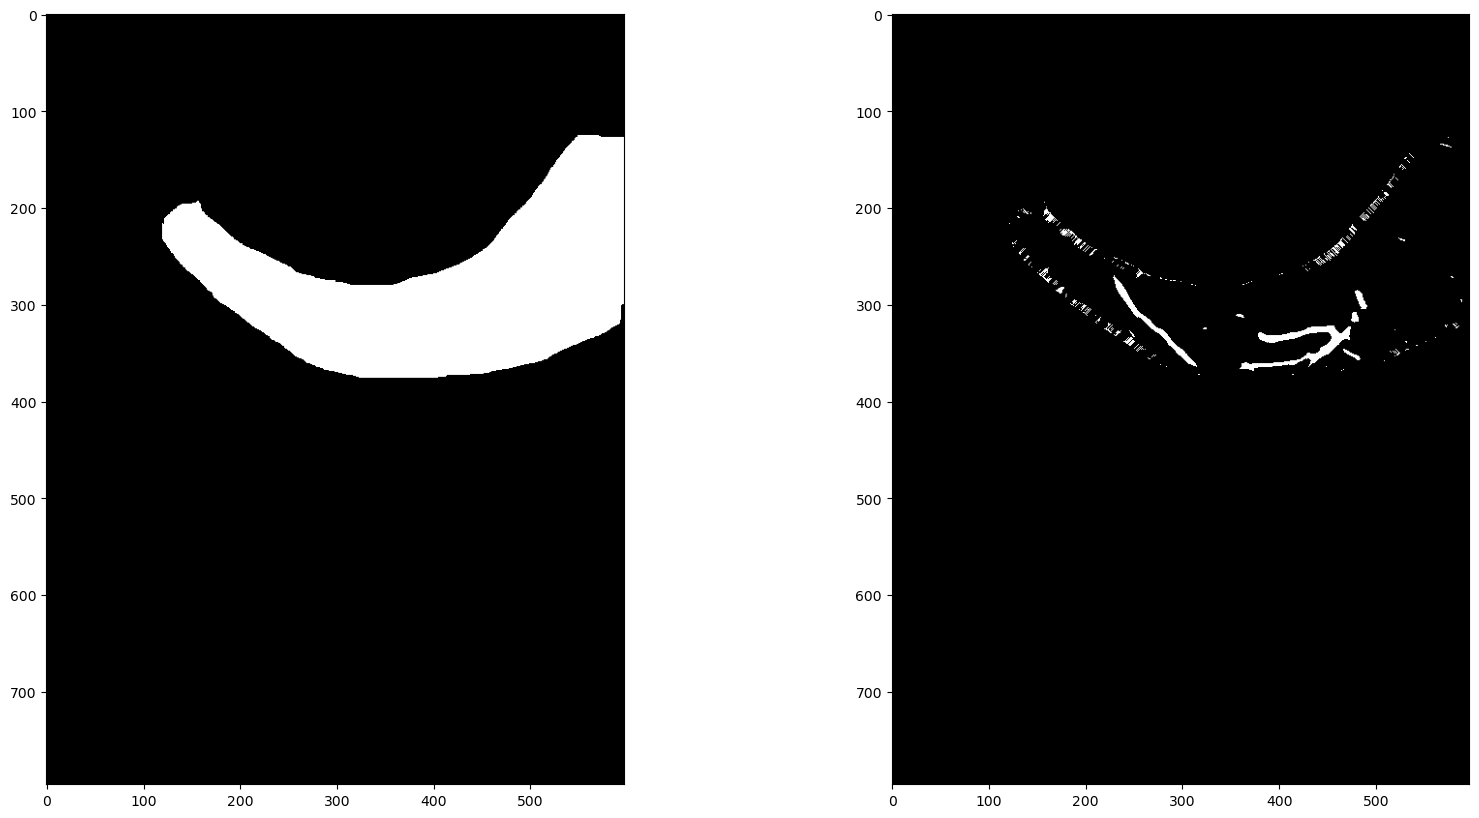

In [4]:
sclera_vessels_shape = sclera_vessels[0].shape
sclera_masks_bw = []                                # array of black and white sclera
sclera_vessels_bw = []                              # array of black and white sclera vessels

# converts the sclera masks to black and white
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    # resize the mask to the sclera vessel shape
    mask = cv2.resize(mask, sclera_vessels_shape[:2][::-1])
    
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_masks_bw.append(mask)

# converts the sclera vessels to black and white
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
    # transparence becomes black
    mask[mask[:, :, 3] == 0] = [0, 0, 0, 0]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)
    
    sclera_vessels_bw.append(mask)

# show the sclera masks and sclera vessels
for i in range(5):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sclera_masks_bw[i], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(sclera_vessels_bw[i], cmap='gray')
    plt.show()

# Mask application

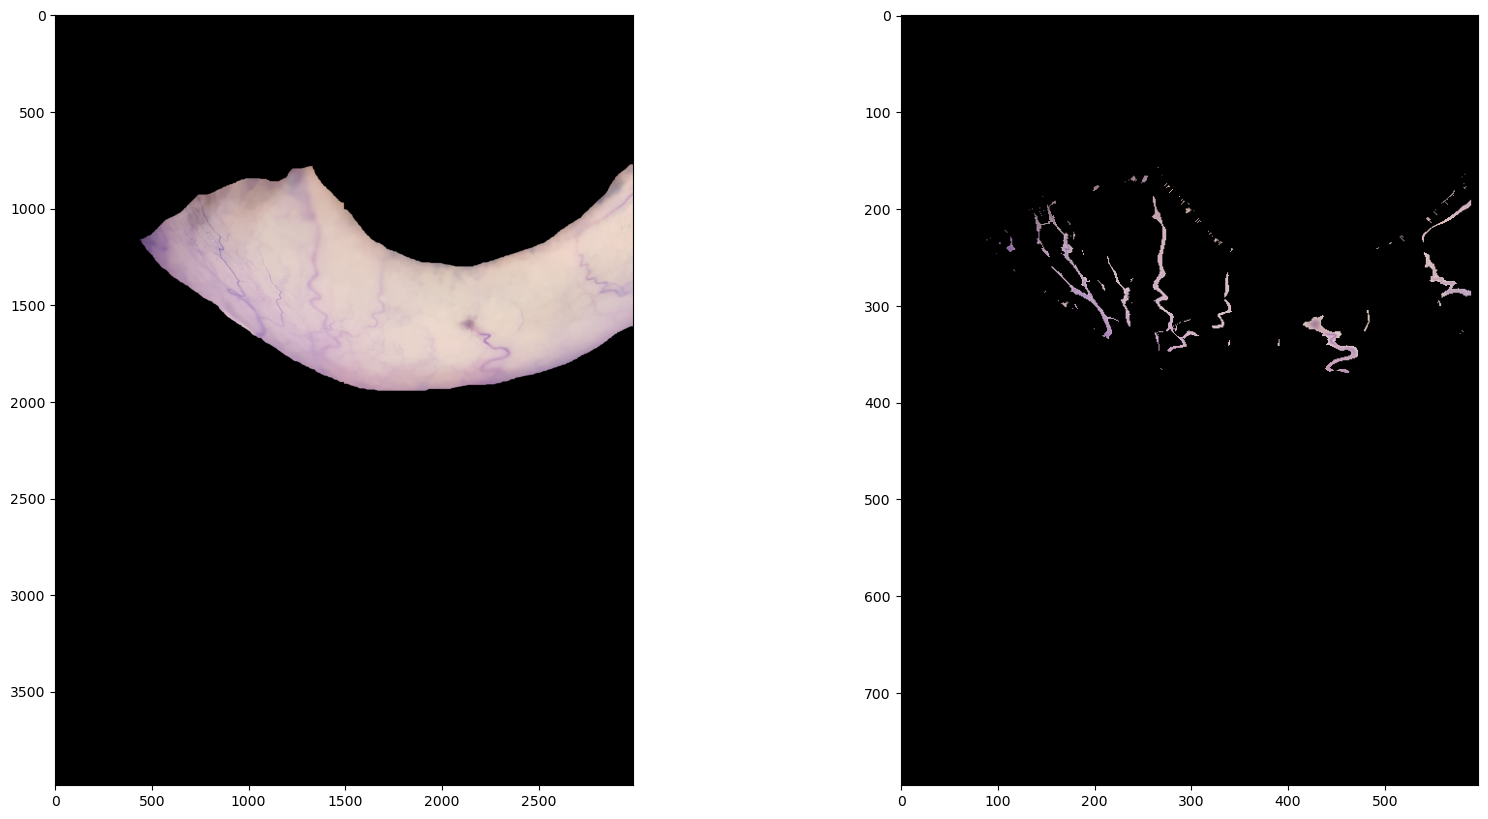

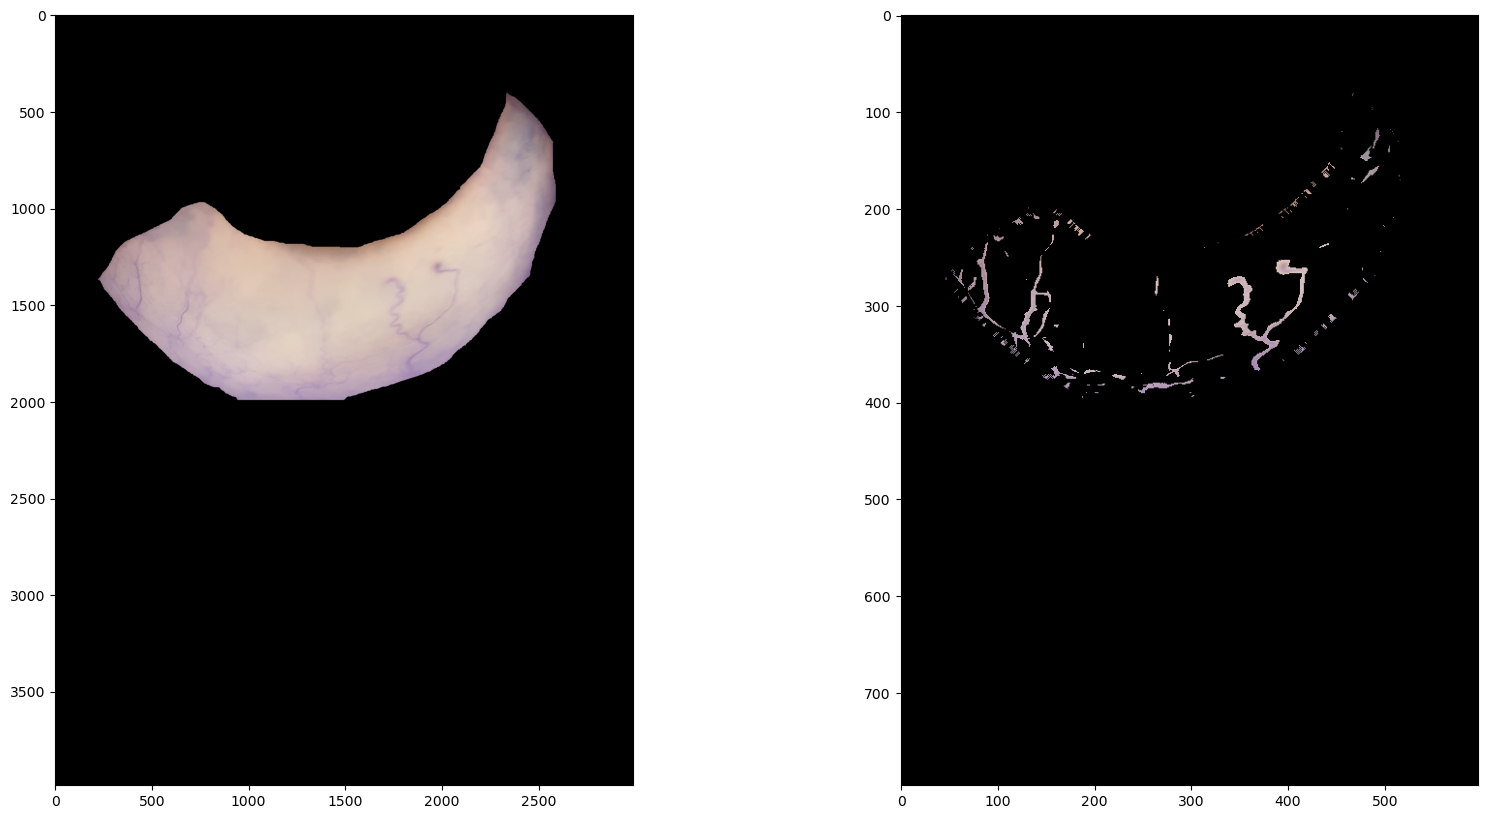

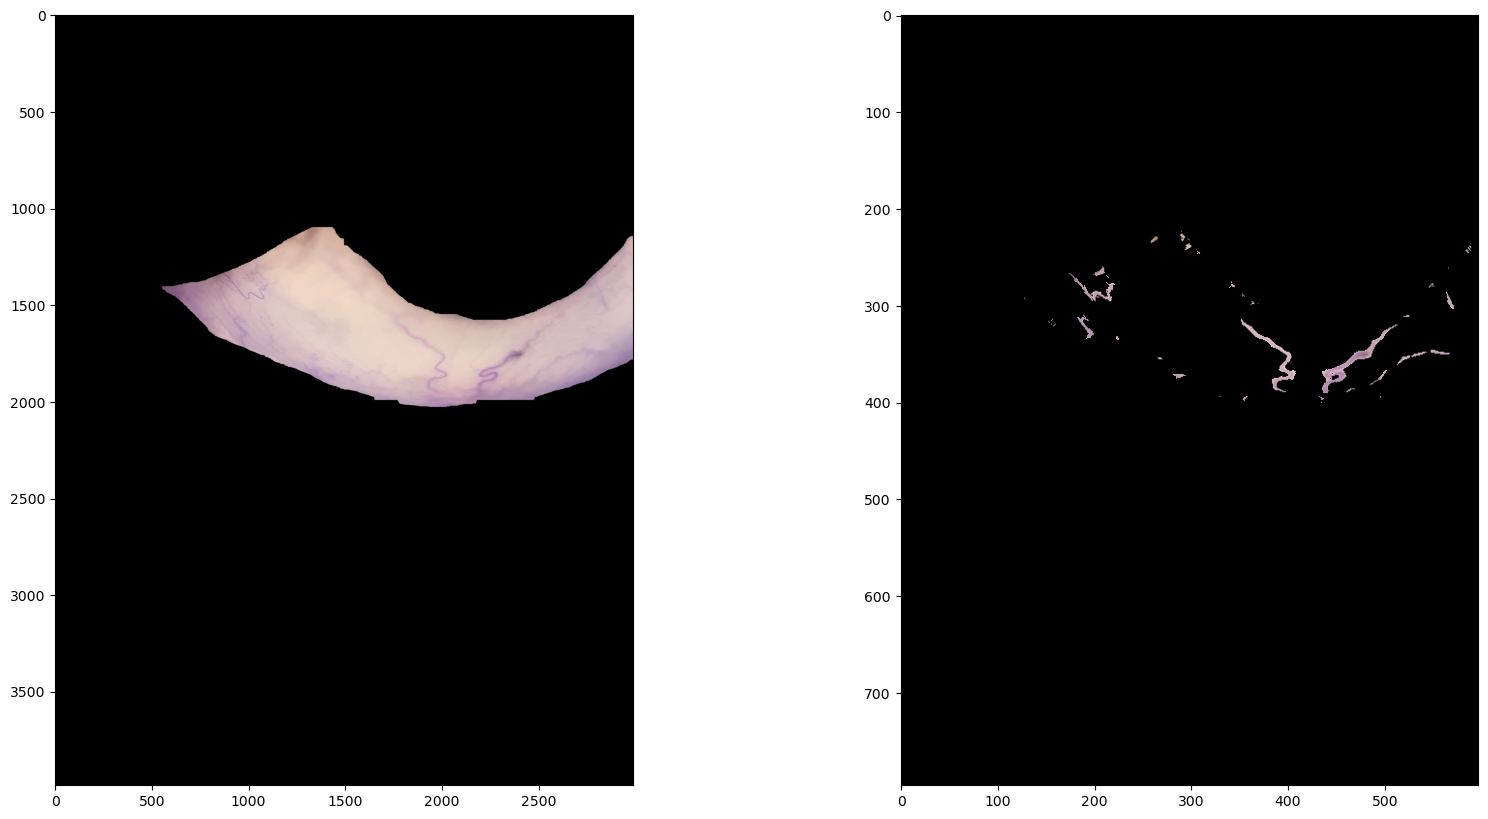

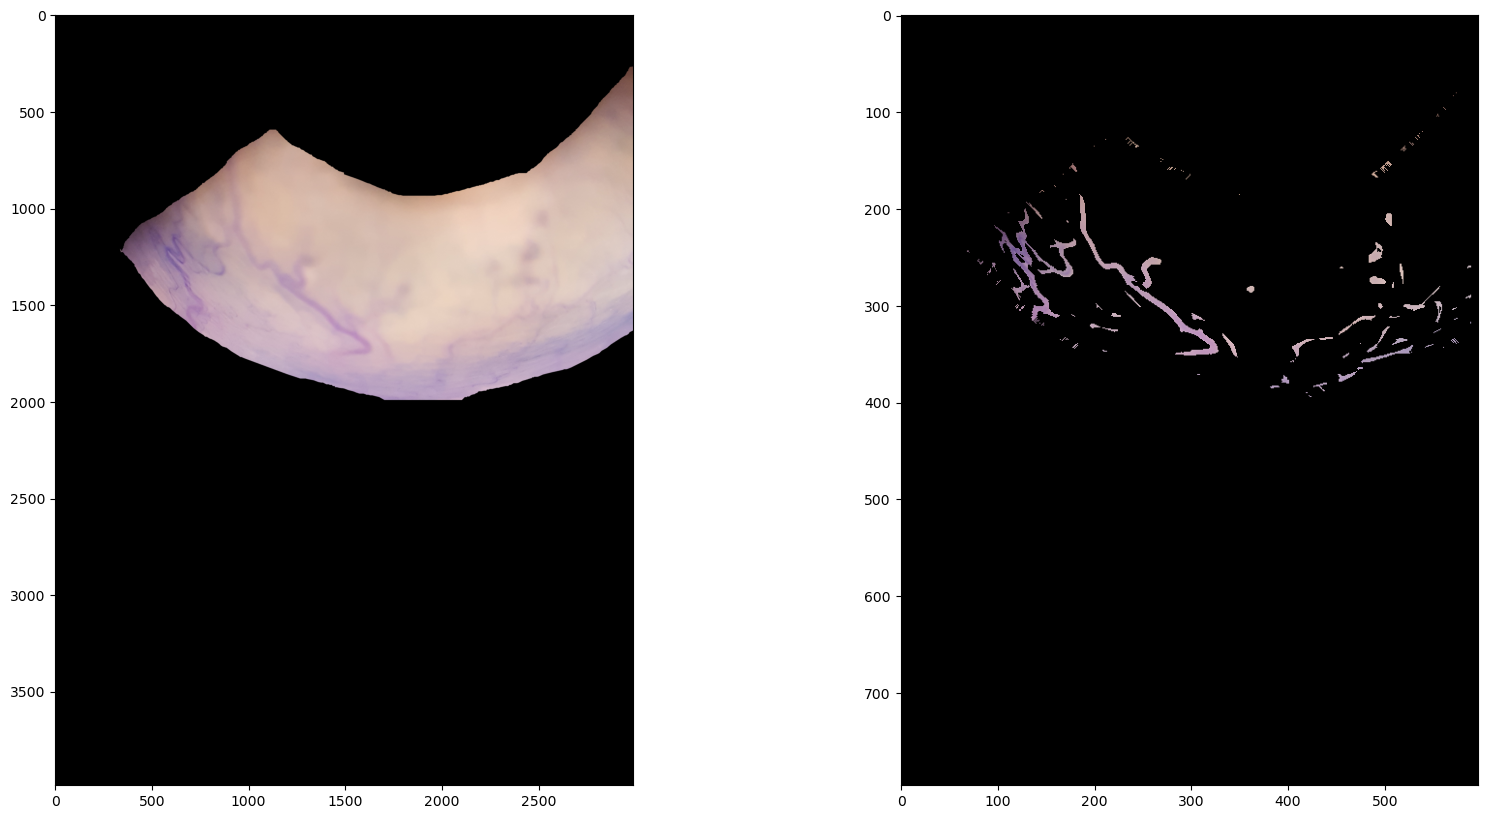

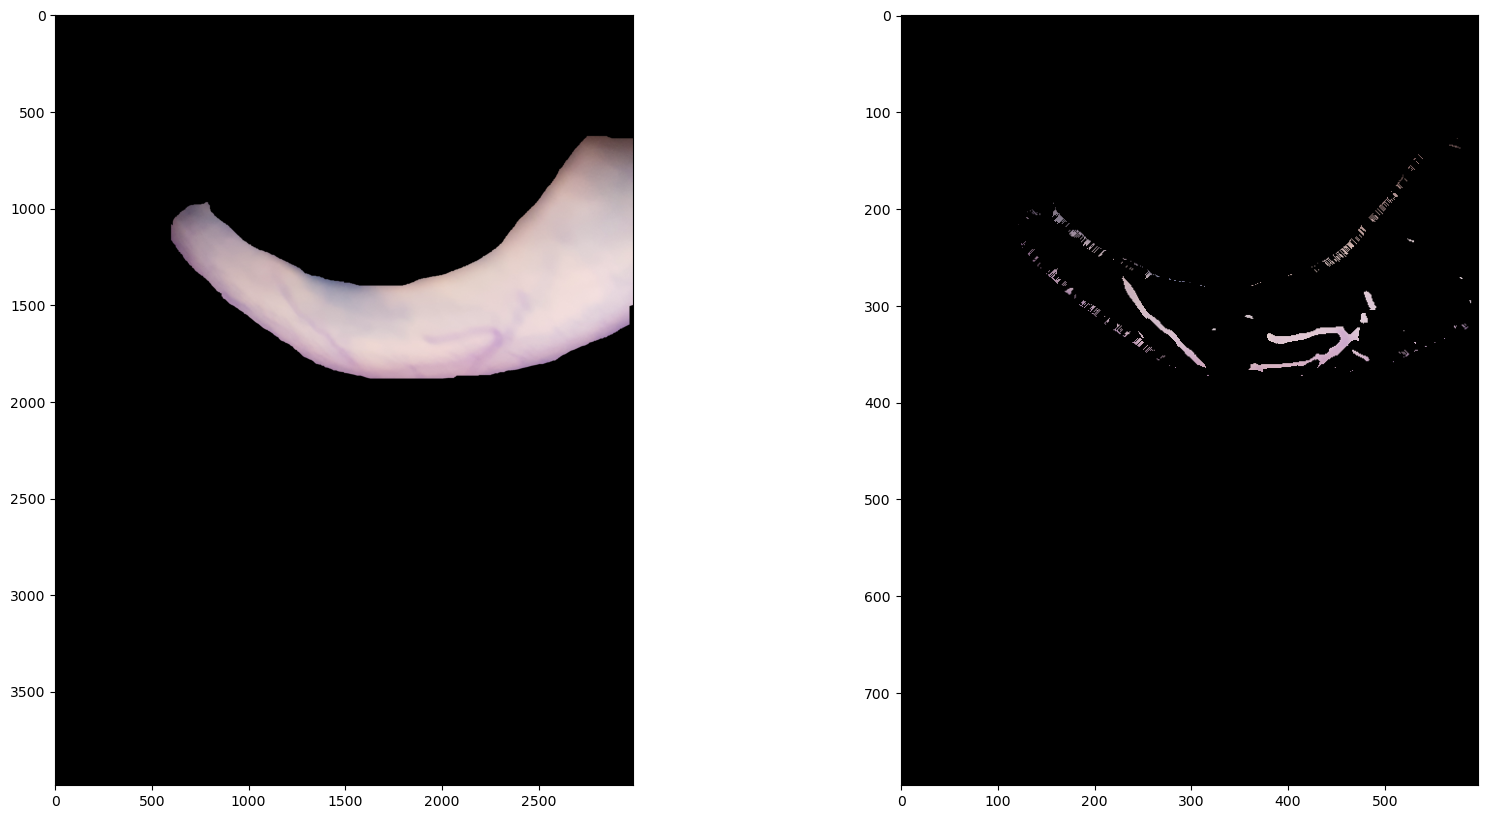

In [5]:
# sclera_masks = []                                # array of coulored sclera
# sclera_vessels = []                              # array of coulored sclera vessels

# sclera_masks_bw = []                                # array of black and white sclera
# sclera_vessels_bw = []                                # array of black and white sclera vessels

sclera_masked = []                                    # array of sclera with only sclera part is coloured
sclera_vessels_masked = []                            # array of sclera with only sclera part is coloured

for l in range (len(sclera_masks_bw)):                               # Per ogni maschera della sclera
    sclera_masked.append(sclera_masks[l])                            # Carica la foto orignale sull'array
    for i in range(sclera_masks_bw[l].shape[0]):                     # Itera sulle righe
        for j in range(sclera_masks_bw[l].shape[1]):                 # Itera sulle colonne
            if sclera_masks_bw[l][i, j] == 0:                        # Se il pixel della maschera è nero
                sclera_masked[l][i, j] = [0, 0, 0]                   # Rendi il pixel corrispondente della sclera nero
            else:                                                    # Altrimenti\n",
                sclera_masked[l][i, j] = sclera_masks[l][i, j]       # Rendi il pixel corrispondente della sclera del colore originale
for l in range (len(sclera_vessels_bw)):                                       # Per ogni maschera dei vasi
    sclera_vessels_masked.append(sclera_vessels[l])                            # Carica la foto orignale sull'array
    for i in range(sclera_vessels_bw[l].shape[0]):                             # Itera sulle righe
        for j in range(sclera_vessels_bw[l].shape[1]):                         # Itera sulle colonne
            if sclera_vessels_bw[l][i, j] == 0:                                # Se il pixel della maschera è nero
                sclera_vessels_masked[l][i, j] = [0, 0, 0, 255]                           # Rendi il pixel corrispondente della sclera nero
            else:                                                                    # Altrimenti
                sclera_vessels_masked[l][i, j] = sclera_vessels[l][i, j]       # Rendi il pixel corrispondente della sclera del colore originale
                
# Visualizza l'immagine risultante
for i in range(5):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sclera_masked[i])
    plt.subplot(1, 2, 2)
    plt.imshow(sclera_vessels_masked[i])
    plt.show()                

# Density calculation

In [6]:
# calculate the density of the vessels in the sclera
vessels_density = []
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    
    vessels_volume = cv2.countNonZero(sclera_vessels[index])
    sclera_volume = cv2.countNonZero(mask)

    densita = vessels_volume / sclera_volume
    vessels_density.append(densita)

  0%|                                                                                                                                          | 0/95 [00:00<?, ?it/s]


error: OpenCV(4.7.0) /io/opencv/modules/core/src/count_non_zero.dispatch.cpp:128: error: (-215:Assertion failed) cn == 1 in function 'countNonZero'


# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# threshold of hb to define an anemic patient
# (11 is the best because it allows to have a balanced dataset)
threshold_hb = 11

X = np.array(vessels_density).reshape(-1, 1)
y = np.zeros(X.shape[0])

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    if float(row['hb'].replace(',', '.')) < threshold_hb:
        y[int(row['paziente']) - 1] = 1
    else:
        y[int(row['paziente']) - 1] = 0


# balance the dataset
anemic_indexes = np.where(y == 1)[0]
non_anemic_indexes = np.where(y == 0)[0]

# difference between the number of anemic and non anemic
diff = len(anemic_indexes) - len(non_anemic_indexes)

# remove the excess values
if diff > 0:
    # from anemics
    anemic_indexes = np.random.choice(anemic_indexes, diff, replace=False)
    X = np.delete(X, anemic_indexes, axis=0)
    y = np.delete(y, anemic_indexes, axis=0)
else:
    # from non anemics
    non_anemic_indexes = np.random.choice(non_anemic_indexes, -diff, replace=False)
    X = np.delete(X, non_anemic_indexes, axis=0)
    y = np.delete(y, non_anemic_indexes, axis=0)

print('Numero di anemici: ', np.count_nonzero(y))
print('Numero di non anemici: ', y.shape[0] - np.count_nonzero(y))

# train the model
clf = LogisticRegression()

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())
